In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.modules import activation
torch.set_default_dtype(torch.float)
torch.set_default_device('cuda')
torch.manual_seed(1274)

In [2]:
def fourier_sol(x,t): #100 terms of fourier
  xsum=0
  ysum=0
  for n in range(1,101):
    xsum=xsum+((-1)**n/(n**2))*torch.cos(n*torch.pi*x)*torch.exp(-((n*torch.pi)**2)*t)
  u=1/3+(4/(torch.pi**2))*xsum
  return u

def plot3D(x,t,y):
  x_plot=x.detach().squeeze(1).cpu()
  t_plot=t.detach().squeeze(1).cpu()
  X,T= torch.meshgrid(x_plot,t_plot)
  X=X.cpu()
  T=T.cpu()
  F_xt = y.detach().cpu()
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

def plot3D_Matrix(x,t,y):
  X,T= x.detach().cpu(),t.detach().cpu()
  F_xt = y.reshape(shape=[1000,1000]).transpose(1,0).detach().cpu()
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

layers = np.array([2,32,32,1])

class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0 #For the Optimizer
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a

c:\Users\Mohammad\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


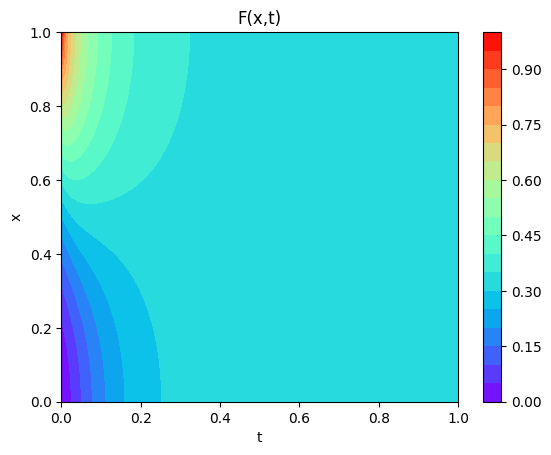

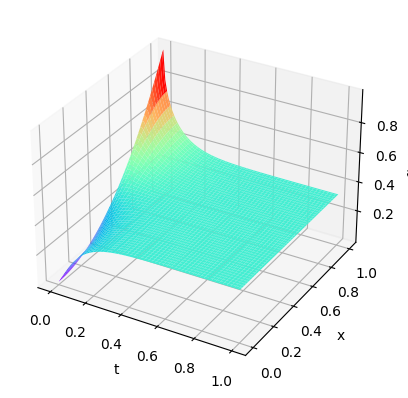

In [3]:
x=torch.linspace(0,1,100).view(-1,1).requires_grad_(True)
t=torch.linspace(0,1,100).view(-1,1).requires_grad_(True)
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))
all_points=torch.hstack((X.transpose(1,0).flatten().view(-1,1),T.transpose(1,0).flatten().view(-1,1)))
u_fourier=fourier_sol(X,T)
plot3D(x,t,u_fourier)
# testing data
x_test=torch.linspace(0,1,1000).view(-1,1).requires_grad_(True)
t_test=torch.linspace(0,1,1000).view(-1,1).requires_grad_(True)
X_test,T_test=torch.meshgrid(x_test.squeeze(1),t_test.squeeze(1))
test_points=torch.hstack((X_test.transpose(1,0).flatten().view(-1,1),T_test.transpose(1,0).flatten().view(-1,1)))

Training Loss-----Test Loss
2541.842 --- 0.13673724
0.10935509 --- 0.0039666123
0.091678105 --- 0.0038738954
0.08750745 --- 0.00383737
0.08527028 --- 0.003799545
0.08455494 --- 0.003764082
0.08413268 --- 0.0037220463
0.083665065 --- 0.0036762818
0.11167607 --- 0.0036420363
0.08272646 --- 0.0035757916
0.082363315 --- 0.0035359694


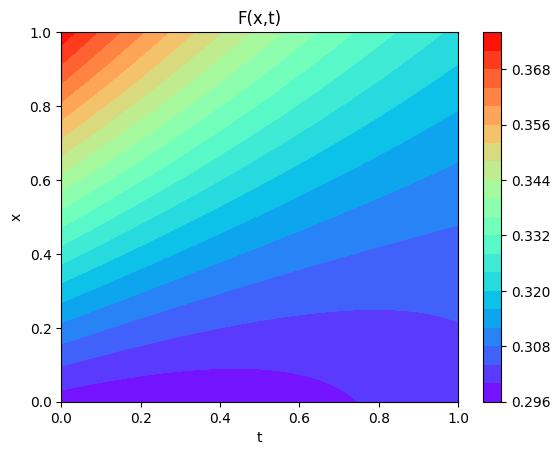

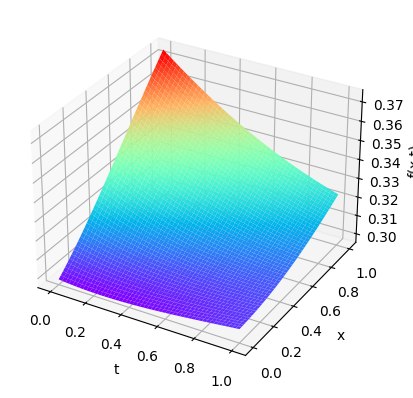

In [11]:
pinn=FCN(layers)
pinn.to(torch.device('cuda'))
optimiser=torch.optim.Adam(pinn.parameters(),lr=1e-3,amsgrad=False)
for i in range(15001):
  if i==0:
    print("Training Loss-----Test Loss")
  optimiser.zero_grad()

# random hyperparameters chosen
  lambda0, lambda1, lambda2, lambda3=1,1,1,1e4

# Initial condition loss term
  x0=torch.hstack((x,torch.zeros_like(x)))
  u=pinn.forward(x0)
  loss_IC=torch.mean((u.squeeze(1)-torch.square(x.squeeze(1)))**2)

# Boundary condition loss term
  LB=torch.hstack((torch.zeros_like(t),t))
  u=pinn.forward(LB)
  u_x=torch.autograd.grad(u,LB,torch.ones([LB.shape[0], 1]), create_graph=True)[0][:,[0]]
  loss_BC0=torch.mean(torch.square(u_x.squeeze(1)))

  RB=torch.hstack((torch.ones_like(t),t))
  u=pinn.forward(RB)
  u_x=torch.autograd.grad(u,RB,torch.ones([RB.shape[0], 1]), create_graph=True)[0][:,[0]]
  loss_BC1=torch.mean(torch.square(u_x.squeeze(1)))

# PDE loss term
  u=pinn.forward(all_points)
  u_x_t=torch.autograd.grad(u,all_points,torch.ones([all_points.shape[0], 1]), retain_graph=True, create_graph=True)[0]
  u_xx_tt=torch.autograd.grad(u_x_t,all_points,torch.ones(u_x_t.shape), create_graph=True)[0]
  loss_PDE=torch.mean(torch.square(u_x_t[:,1]-u_xx_tt[:,0]))

  loss=lambda0*loss_IC+lambda1*loss_BC0+lambda2*loss_BC1+lambda3*loss_PDE
  loss.backward()
  optimiser.step()
  if i%(1500)==0:
    with torch.no_grad():
      test_loss=torch.mean(torch.square(pinn.forward(test_points).squeeze(1)-fourier_sol(test_points[:,0],test_points[:,1])))
    print(loss.detach().cpu().numpy(),'---',test_loss.detach().cpu().numpy())  
plot3D_Matrix(X_test,T_test,pinn(test_points))